In [20]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split

## Load Iris Dataset

In [21]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris["data"], columns=iris["feature_names"])
df["y"] = iris["target"]
df["y"] = df["y"].map(dict(enumerate(iris.target_names)))

# Keep only rows where y is `Virginica` or `Versicolor`
df = df[df["y"].isin(["virginica", "versicolor"])]

# Keep only `sepal length (cm)` and `sepal width (cm)` columns

columns_to_keep = ["sepal length (cm)", "sepal width (cm)"]
df = df.loc[:, columns_to_keep + ["y"]]

In [22]:
print(f"Number of instances: {len(df)}")

Number of instances: 100


## Joint Plot

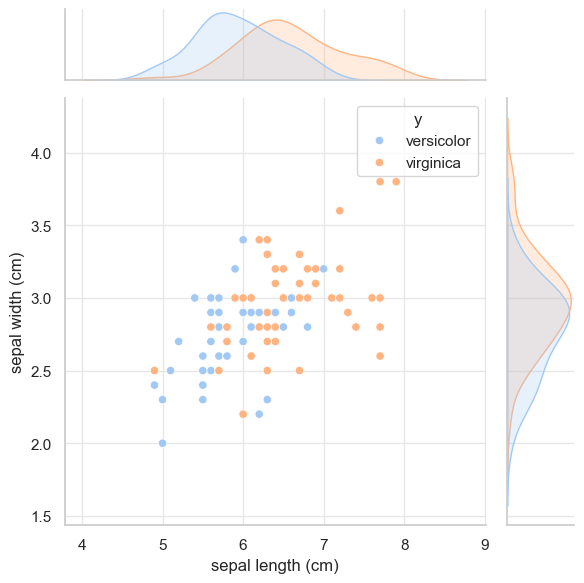

In [23]:
sns.set(style="whitegrid", palette="pastel", rc={"grid.color": ".9"})

sns.jointplot(df, x="sepal length (cm)", y="sepal width (cm)", hue="y")

sns.despine()

plt.tight_layout()
plt.show()

## Split Train/Test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1), df["y"], test_size=0.3, random_state=42, stratify=df["y"]
)

---

## LDA/QDA Training

In [25]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

In [26]:
def plot_confusion_matrix(
    y_true: Union[pd.Series, np.ndarray],
    y_pred: Union[pd.Series, np.ndarray],
):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=iris.target_names[1:]
    )
    disp.plot(cmap="Blues")
    plt.grid(False)
    plt.gca().set_frame_on(False)
    plt.show()


def display_decision_boundary(
    model, X: pd.DataFrame, y: pd.Series, xlabel: str, ylabel: str, ax=None
):
    """Display the decision boundary of a model.

    Parameters
    ----------
    model : _type_
        Model to display the decision boundary of.
    X : pd.DataFrame
        Dataframe containing the features.
    y : pd.Series
        Series containing the target.
    xlabel : str
        Feature to display on the x-axis.
    ylabel : str
        Feature to display on the y-axis.
    ax : matplotlib.axes, optional
        The axes on which to plot. If None, a new figure will be created.
    """
    # Use provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
        xlabel=xlabel,
        ylabel=ylabel,
        alpha=0.5,
        ax=ax,
    )

    # Add scatterplot
    sns.scatterplot(data=X, x=xlabel, y=ylabel, hue=y, alpha=0.5, ax=ax)

    return disp


In [27]:
# This dictionary is needed to build a comparative DataFrame between models
models_accuracy_dict = {
    "Model": ["LDA", "QDA", "RDA(0)", "RDA(0.5)", "RDA(0.75)"],
    "Accuracy": [],
}

### LDA

In [28]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)


              precision    recall  f1-score   support

  versicolor       0.65      0.87      0.74        15
   virginica       0.80      0.53      0.64        15

    accuracy                           0.70        30
   macro avg       0.73      0.70      0.69        30
weighted avg       0.72      0.70      0.69        30



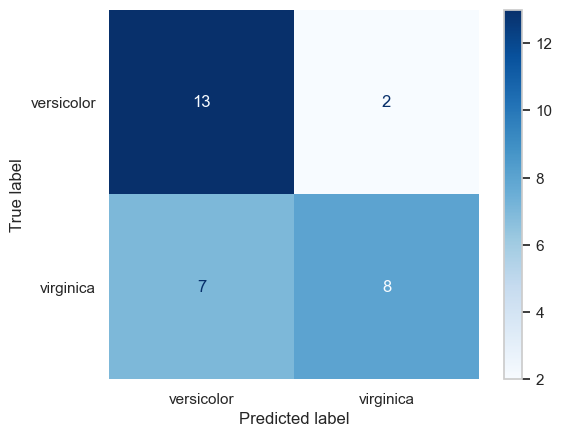

In [29]:
print(classification_report(y_test, y_pred_lda))
plot_confusion_matrix(y_test, y_pred_lda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_lda))

---

### QDA

In [30]:
qda = QuadraticDiscriminantAnalysis()

qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)

              precision    recall  f1-score   support

  versicolor       0.63      0.80      0.71        15
   virginica       0.73      0.53      0.62        15

    accuracy                           0.67        30
   macro avg       0.68      0.67      0.66        30
weighted avg       0.68      0.67      0.66        30



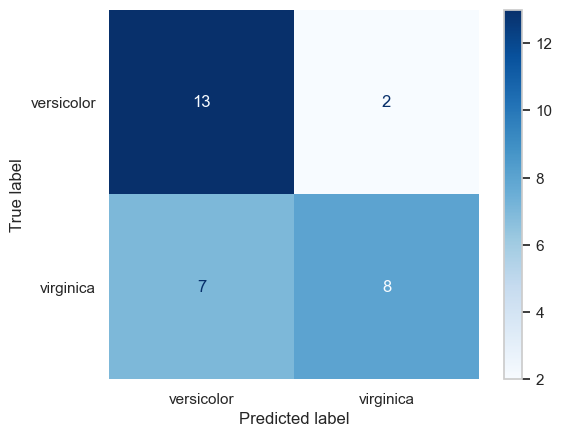

In [31]:
print(classification_report(y_test, y_pred_qda))
plot_confusion_matrix(y_test, y_pred_lda)
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, y_pred_qda))

---

### RDA

Primero se responderá a la siguiente pregunta: ¿Por qué no vamos a emplear un RDA(0) o RDA(1)? 

RDA introduce el parámetro de regularización `shrinkage`, que combina las ventajas de LDA y QDA. LDA asume que la covarianza de las clases es común, mientras que QDA asume lo contrario. Es decir, en el caso de LDA, la forma de la nube de puntos es similar para la distribución de ambas clases, mientras que las nubes de puntos para cada clase que asume QDA pueden tener formas distintas. La idea de `shrinkage` es “encoger” la matriz de covarianza específica de cada clase hacia una matriz común.

$\tilde{\Sigma}_k = (1-\alpha)\Sigma_k + \alpha\Sigma$

donde $\Sigma_k$ es la covarianza de la clase k (Asunción de QDA), $\Sigma$ es la covarianza global (Asunción de LDA) y $\alpha \in [0,1]$ es el parámetro de regularización de `shrinkage`.

Por lo tanto, si $\alpha$ = 0, entonces no se está aplicando la regularización, por lo que se usan las matrices de covarianza $\Sigma_k$ originales; y esto equivaldría a QDA. Sin embargo, si $\alpha = 1$, se usa la matriz de covarianza común $\Sigma$ para todas las clases; y esto equivale a LDA.

Utilizar $\alpha$ entre 0 y 1 (0.25, 0.5, 0.75) da como resultado la combinación entre LDA y QDA

In [32]:
shrinkage = [0.25, 0.5, 0.75]
rda_models = {}
for shr in shrinkage:
    rda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=shr)
    rda.fit(X_train, y_train)
    y_pred = rda.predict(X_test)
    rda_models[shr] = {"model": rda, "preds": y_pred}


#### RDA(0.25)

              precision    recall  f1-score   support

  versicolor       0.67      0.93      0.78        15
   virginica       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



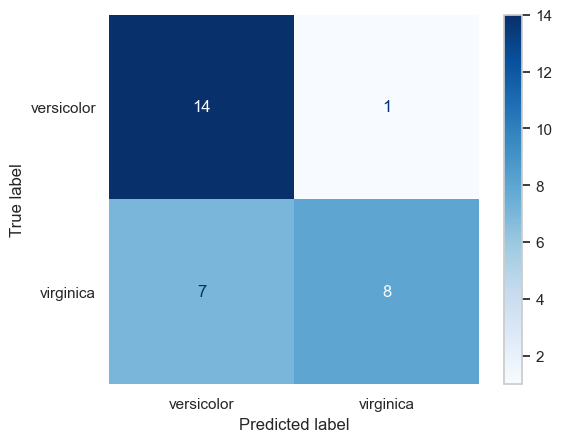

In [33]:
print(classification_report(y_test, rda_models[0.25]["preds"]))
plot_confusion_matrix(y_test, rda_models[0.25]["preds"])
models_accuracy_dict["Accuracy"].append(accuracy_score(y_test, rda_models[0.25]["preds"]))

#### RDA(0.5)

              precision    recall  f1-score   support

  versicolor       0.67      0.93      0.78        15
   virginica       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



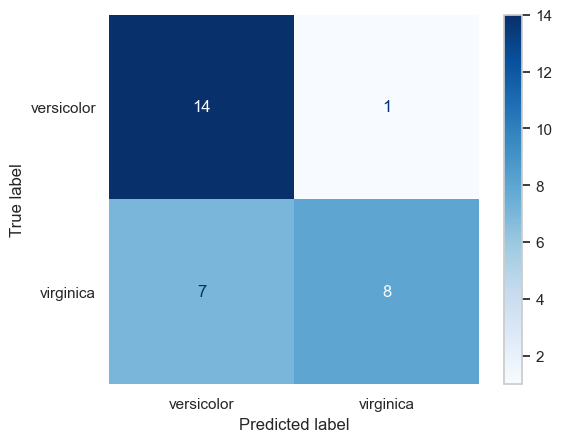

In [34]:
print(classification_report(y_test, rda_models[0.5]["preds"]))
plot_confusion_matrix(y_test, rda_models[0.5]["preds"])
models_accuracy_dict["Accuracy"].append(
    accuracy_score(y_test, rda_models[0.5]["preds"])
)

#### RDA(0.75)

              precision    recall  f1-score   support

  versicolor       0.67      0.93      0.78        15
   virginica       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30



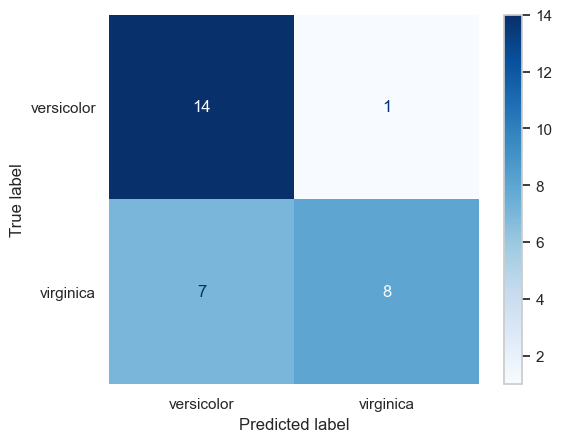

In [35]:
print(classification_report(y_test, rda_models[0.75]["preds"]))
plot_confusion_matrix(y_test, rda_models[0.75]["preds"])
models_accuracy_dict["Accuracy"].append(
    accuracy_score(y_test, rda_models[0.75]["preds"])
)

## Model Accuracy Comparision

In [36]:
pd.DataFrame(models_accuracy_dict)

,Model,Accuracy
0,LDA,0.700000
1,QDA,0.666667
2,RDA(0),0.733333
3,RDA(0.5),0.733333
4,RDA(0.75),0.733333


Cualquiera de las tres variaciones de **RDA** obtuvieron el mismo Accuracy. **RDA** ofrece un 4% más de Accuracy que **LDA** y un 9.5% más que **QDA**. **QDA** es el método con menor Accuracy

## Display the Decision Boundary

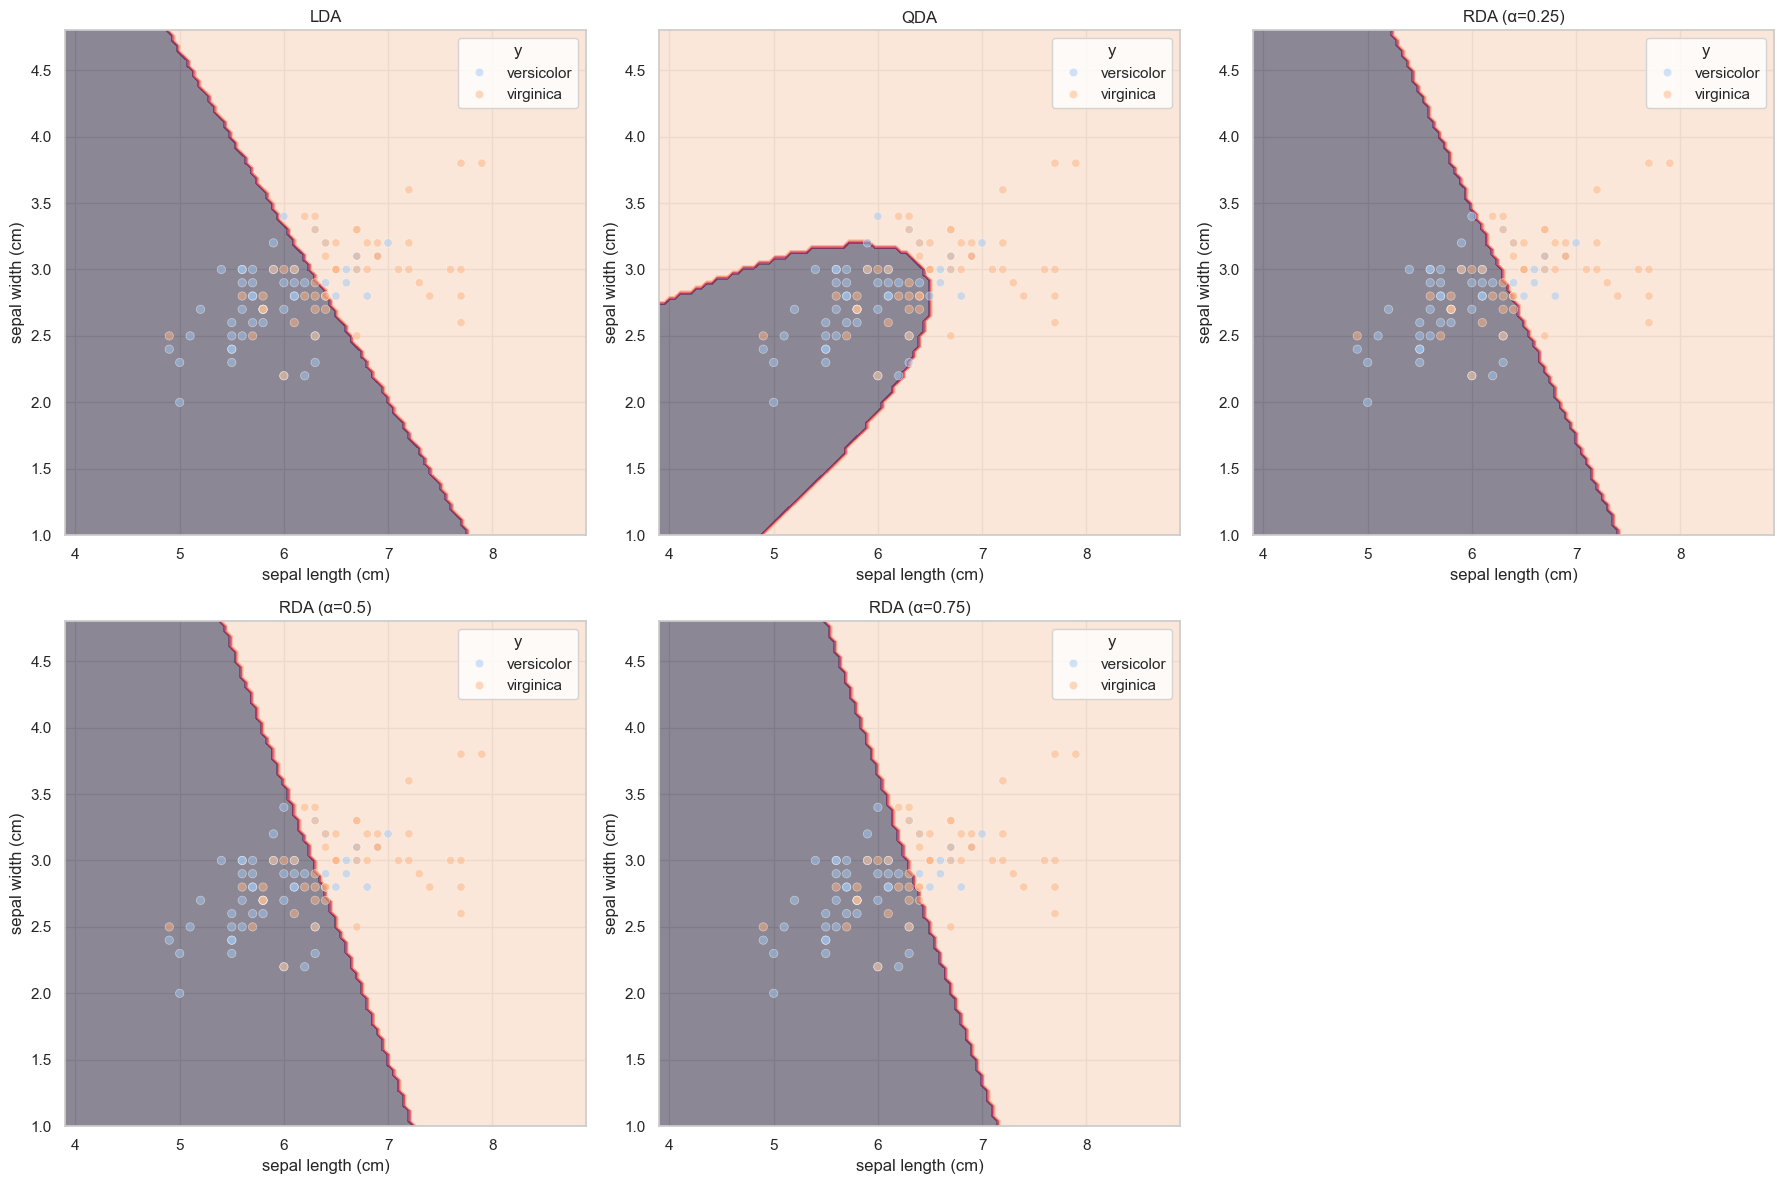

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot each model in a different subplot
models = {
    "LDA": lda,
    "QDA": qda,
    "RDA (α=0.25)": rda_models[0.25]["model"],
    "RDA (α=0.5)": rda_models[0.5]["model"],
    "RDA (α=0.75)": rda_models[0.75]["model"],
}

for i, (name, model) in enumerate(models.items()):
    display_decision_boundary(
        model,
        df.drop("y", axis=1),
        df["y"],
        "sepal length (cm)",
        "sepal width (cm)",
        ax=axes[i],
    )
    axes[i].set_title(f"{name}")

# Remove unused subplot if necessary
if len(models) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

#### Forma de las fronteras de decisión

1. LDA
Se observa claramente una frontera de decisión lineal. Esto se debe a que LDA asume que ambas clases comparten la misma matriz de covarianza, es decir, asume la misma forma en la "nube" de puntos.

2. QDA
Se observa una frontera de decisión curva, propia de un modelo discriminante que utiliza términos de segundo grado. Esto proviene de la asunción que toma QDA acerca de la matriz de covarianza de la distribución de las clases. En este caso, se trata de una matriz de covarianza no compartida, por lo que se entiende que la forma de la distribución de los puntos para cada clasde es distinta.

3. RDA
En este caso se observa una frontera de decisión bastante lineal en los tres casos. Esto se debe a que la implementación que proporciona `scikit-learn` mediante el uso del parámetro `shrinkage` en `LinearDiscriminantAnalysis` simplemente controla la regularización de la matriz de covarianza compartida, sin modificar la asunción fundamental de LDA de que todas las clases comparten la misma matriz de covarianza. De tal manera que cuando mayor sea ese valor de `shrinkage` mayor regularización sobre la matriz de covarianza compartida. Esto proporciona una menor sensibilidad a la variación sobre los datos aumentando el sesgo

El hecho de que QDA asuma que cada clase tiene su propia matriz de covarianza produce fronteras de decisión cuadráticas que reflejan las características peculiares de cada grupo. Sin embargo, la aplicación de la regularización establece una "contracción" de estas matrices hacia una común, lo que suaviza las diferencias entre las clases. De todas formas, es necesario tener en cuenta lo mencionado acerca de la implementación con `scikit-learn`